In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp "/content/drive/MyDrive/Colab Notebooks/closet_ai/data/fashion_examples.zip" ./
! cp "/content/drive/MyDrive/Colab Notebooks/closet_ai/data/fashion_dataset.zip" ./

In [4]:
!ls -al

total 26592
drwxr-xr-x 1 root root     4096 Jan 18 07:43 .
drwxr-xr-x 1 root root     4096 Jan 18 07:41 ..
drwxr-xr-x 4 root root     4096 Jan 13 14:33 .config
drwx------ 6 root root     4096 Jan 18 07:42 drive
-rw------- 1 root root 26991216 Jan 18 07:43 fashion_dataset.zip
-rw------- 1 root root   215899 Jan 18 07:43 fashion_examples.zip
drwxr-xr-x 1 root root     4096 Jan 13 14:34 sample_data


In [5]:
!unzip fashion_dataset.zip


Archive:  fashion_dataset.zip
   creating: fashion_dataset/
   creating: fashion_dataset/black_jeans/
  inflating: fashion_dataset/black_jeans/00000000.jpg  
   creating: __MACOSX/
   creating: __MACOSX/fashion_dataset/
   creating: __MACOSX/fashion_dataset/black_jeans/
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000000.jpg  
  inflating: fashion_dataset/black_jeans/00000004.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000004.jpg  
  inflating: fashion_dataset/black_jeans/00000006.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000006.jpg  
  inflating: fashion_dataset/black_jeans/00000007.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000007.jpg  
  inflating: fashion_dataset/black_jeans/00000009.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000009.jpg  
  inflating: fashion_dataset/black_jeans/00000010.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000010.jpg  
  inflating: fashion_dataset/black_jeans/000000

In [6]:
!unzip fashion_examples.zip


Archive:  fashion_examples.zip
   creating: fashion_examples/
  inflating: fashion_examples/black_dress.jpg  
  inflating: fashion_examples/black_jeans.jpg  
  inflating: fashion_examples/blue_shoes.jpg  
  inflating: fashion_examples/red_shirt.jpg  
  inflating: fashion_examples/red_shoes.jpg  


In [7]:
!ls -al

total 26604
drwxr-xr-x 1 root root     4096 Jan 18 07:43 .
drwxr-xr-x 1 root root     4096 Jan 18 07:41 ..
drwxr-xr-x 4 root root     4096 Jan 13 14:33 .config
drwx------ 6 root root     4096 Jan 18 07:42 drive
drwxr-xr-x 9 root root     4096 Jun 23  2020 fashion_dataset
-rw------- 1 root root 26991216 Jan 18 07:43 fashion_dataset.zip
drwxr-xr-x 2 root root     4096 May 29  2020 fashion_examples
-rw------- 1 root root   215899 Jan 18 07:43 fashion_examples.zip
drwxrwxr-x 3 root root     4096 Jun 23  2020 __MACOSX
drwxr-xr-x 1 root root     4096 Jan 13 14:34 sample_data


In [8]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
from keras.optimizers import Adam
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from pyimagesearch.fashionnet import FashionNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

# 데이터 로딩

In [9]:
args = { "dataset":"fashion_dataset", 
        "model":"fashion.model"}


# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)


# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(args["dataset"])))
random.seed(42)
random.shuffle(imagePaths)

# initialize the data, clothing category labels (i.e., shirts, jeans,
# dresses, etc.) along with the color labels (i.e., red, blue, etc.)
data = []
categoryLabels = []
colorLabels = []

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	# extract the clothing color and category from the path and
	# update the respective lists
	(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
	categoryLabels.append(cat)
	colorLabels.append(color)

# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))

# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

# binarize both sets of labels
print("[INFO] binarizing labels...")
categoryLB = LabelBinarizer()
colorLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
colorLabels = colorLB.fit_transform(colorLabels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels, test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY, trainColorY, testColorY) = split


[INFO] loading images...
[INFO] data matrix: 755 images (163.08MB)
[INFO] binarizing labels...


# 모델 정의

In [10]:
# import the necessary packages
from keras.models import Model
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class FashionNet:
	@staticmethod
	def build_category_branch(inputs, numCategories,
		finalAct="softmax", chanDim=-1):
		# utilize a lambda layer to convert the 3 channel input to a
		# grayscale representation
		x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)

		# (CONV => RELU) * 2 => POOL
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# (CONV => RELU) * 2 => POOL
		x = Conv2D(128, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(128, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# define a branch of output layers for the number of different
		# clothing categories (i.e., shirts, jeans, dresses, etc.)
		x = Flatten()(x)
		x = Dense(256)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numCategories)(x)
		x = Activation(finalAct, name="category_output")(x)

		# return the category prediction sub-network
		return x

	@staticmethod
	def build_color_branch(inputs, numColors, finalAct="softmax",
		chanDim=-1):
		# CONV => RELU => POOL
		x = Conv2D(16, (3, 3), padding="same")(inputs)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)

		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# define a branch of output layers for the number of different
		# colors (i.e., red, black, blue, etc.)
		x = Flatten()(x)
		x = Dense(128)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numColors)(x)
		x = Activation(finalAct, name="color_output")(x)

		# return the color prediction sub-network
		return x

	@staticmethod
	def build(width, height, numCategories, numColors,
		finalAct="softmax"):
		# initialize the input shape and channel dimension (this code
		# assumes you are using TensorFlow which utilizes channels
		# last ordering)
		inputShape = (height, width, 3)
		chanDim = -1

		# construct both the "category" and "color" sub-networks
		inputs = Input(shape=inputShape)
		categoryBranch = FashionNet.build_category_branch(inputs,
			numCategories, finalAct=finalAct, chanDim=chanDim)
		colorBranch = FashionNet.build_color_branch(inputs,
			numColors, finalAct=finalAct, chanDim=chanDim)

		# create the model using our input (the batch of images) and
		# two separate outputs -- one for the clothing category
		# branch and another for the color branch, respectively
		model = Model(
			inputs=inputs,
			outputs=[categoryBranch, colorBranch],
			name="fashionnet")

		# return the constructed network architecture
		return model

# 모델 학습

In [11]:

# initialize our FashionNet multi-output network
model = FashionNet.build(96, 96,
	numCategories=len(categoryLB.classes_),
	numColors=len(colorLB.classes_),
	finalAct="softmax")

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"category_output": "categorical_crossentropy",
	"color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

# train the network to perform multi-output classification
H = model.fit(trainX,
	{"category_output": trainCategoryY, "color_output": trainColorY},
	validation_data=(testX,
		{"category_output": testCategoryY, "color_output": testColorY}),
	epochs=EPOCHS,
	verbose=1)
     

[INFO] compiling model...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
19/19 [==============================] - 25s 1s/step - loss: 1.5000 - category_output_loss: 0.7719 - color_output_loss: 0.7281 - category_output_accuracy: 0.7616 - color_output_accuracy: 0.7384 - val_loss: 2.9134 - val_category_output_loss: 1.9767 - val_color_output_loss: 0.9366 - val_category_output_accuracy: 0.3113 - val_color_output_accuracy: 0.4768
Epoch 2/50
19/19 [==============================] - 23s 1s/step - loss: 0.5525 - category_output_loss: 0.3276 - color_output_loss: 0.2249 - category_output_accuracy: 0.8940 - color_output_accuracy: 0.9189 - val_loss: 4.0640 - val_category_output_loss: 2.2345 - val_color_output_loss: 1.8294 - val_category_output_accuracy: 0.3113 - val_color_output_accuracy: 0.3907
Epoch 3/50
19/19 [==============================] - 22s 1s/step - loss: 0.3865 - category_output_loss: 0.2432 - color_output_loss: 0.1433 - category_output_accuracy: 0.9288 - color_output_accuracy: 0.9487 - val_loss: 4.7458 - val_category_output_loss: 1.9717 - val_col

# 모델 저장

In [12]:
# save the model to disk
print("[INFO] serializing network...")
# model.save(args["model"])
model.save('classify.h5')

[INFO] serializing network...


# 학습 로스 보이기

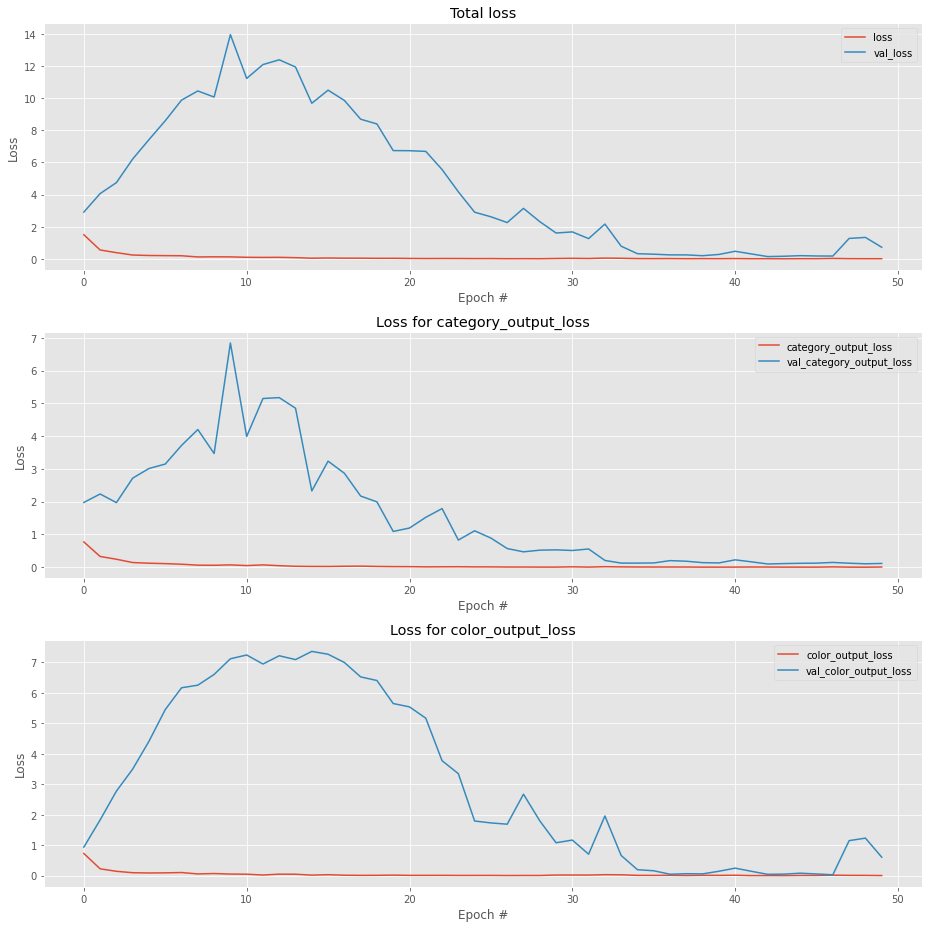

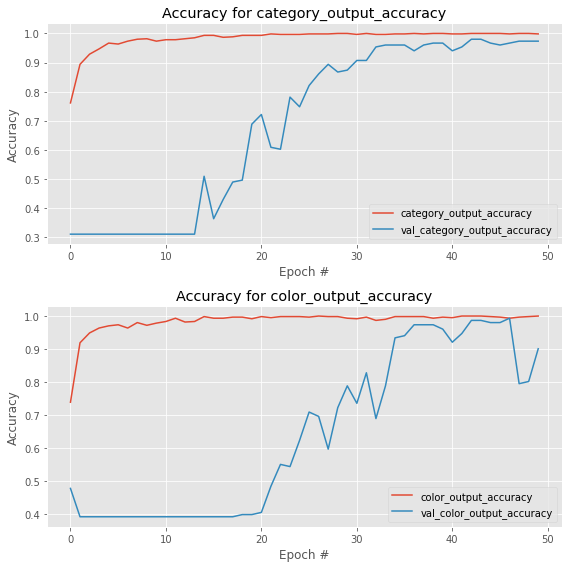

In [13]:
# plot the total loss, category loss, and color loss
lossNames = ["loss", "category_output_loss", "color_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
	ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()

# save the losses figure
plt.tight_layout()
plt.show()
plt.close()

# create a new figure for the accuracies
accuracyNames = ["category_output_accuracy", "color_output_accuracy"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))

# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
	# plot the loss for both the training and validation data
	ax[i].set_title("Accuracy for {}".format(l))
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Accuracy")
	ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
	ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()

# save the accuracies figure
plt.tight_layout()
plt.show()
plt.close()

In [14]:
# import the necessary packages

from tensorflow.keras.utils import img_to_array
# from keras.preprocessing.image import img_to_array
from keras.models import load_model
import tensorflow as tf
import numpy as np
import argparse
import imutils
import pickle
import cv2
     

In [15]:
# 모델 불러오기
from keras.models import load_model
model = load_model('classify.h5')

# 모델 로딩과 예측

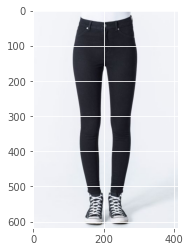

[INFO] loading network...


OSError: ignored

In [18]:
# USAGE
# python classify.py --model output/fashion.model \
#	--categorybin output/category_lb.pickle --colorbin output/color_lb.pickle \
#	--image examples/black_dress.jpg



# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-m", "--model", required=True,
# 	help="path to trained model model")
# ap.add_argument("-l", "--categorybin", required=True,
# 	help="path to output category label binarizer")
# ap.add_argument("-c", "--colorbin", required=True,
# 	help="path to output color label binarizer")
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# args = vars(ap.parse_args())

args = { "model":"fashion.model", 
        "image":"/content/black_jeans.jpg" }
# args = { "model":"fashion.model", 
#         "image":"/content/KakaoTalk_20230113_160625323_01.jpg" }

# load the image
image = cv2.imread(args["image"])
output = imutils.resize(image, width=400)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# load the trained convolutional neural network from disk, followed
# by the category and color label binarizers, respectively
print("[INFO] loading network...")
model = load_model(args["model"], custom_objects={"tf": tf})

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
(categoryProba, colorProba) = model.predict(image)

categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = categoryLB.classes_[categoryIdx]
colorLabel = colorLB.classes_[colorIdx]

# draw the category label and color label on the image
categoryText = "category: {} ({:.2f}%)".format(categoryLabel,
	categoryProba[0][categoryIdx] * 100)
colorText = "color: {} ({:.2f}%)".format(colorLabel,
	colorProba[0][colorIdx] * 100)
print(categoryText)
print(colorText)
